### Vehicle Detection Tracking Project
---

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

In [2]:
reset -sf

In [23]:
import pandas as pd
import numpy as np
import random
import cv2 
import glob
import time

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.feature import hog
from sklearn.svm import LinearSVC
from scipy.ndimage.measurements import label
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from moviepy.editor import VideoFileClip

### Load Data

In [2]:
car = glob.glob('./train_set/vehicles/**/*.png')
non_car = glob.glob('./train_set/non-vehicles/**/*.png')

In [3]:
len(car), len(non_car)

(8792, 8968)

In [4]:
# Take 10 random sample of images and show
def plot_img(img, label, sample=10):
    print('Image Shape:', mpimg.imread(img[0]).shape)
    plt.figure(figsize=(18, 7))
    for n in range(sample):
        plt.subplot(2, sample/2, n+1)
        random_int = random.randint(0, len(img))
        plt.axis('off')
        plt.title(label)
        plt.imshow(mpimg.imread(img[random_int]).squeeze())

Image Shape: (64, 64, 3)


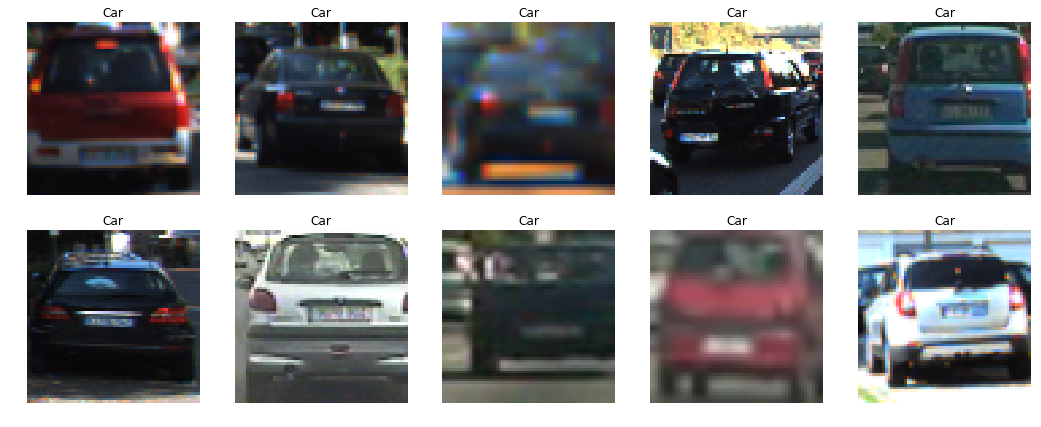

In [5]:
plot_img(car, 'Car')

Image Shape: (64, 64, 3)


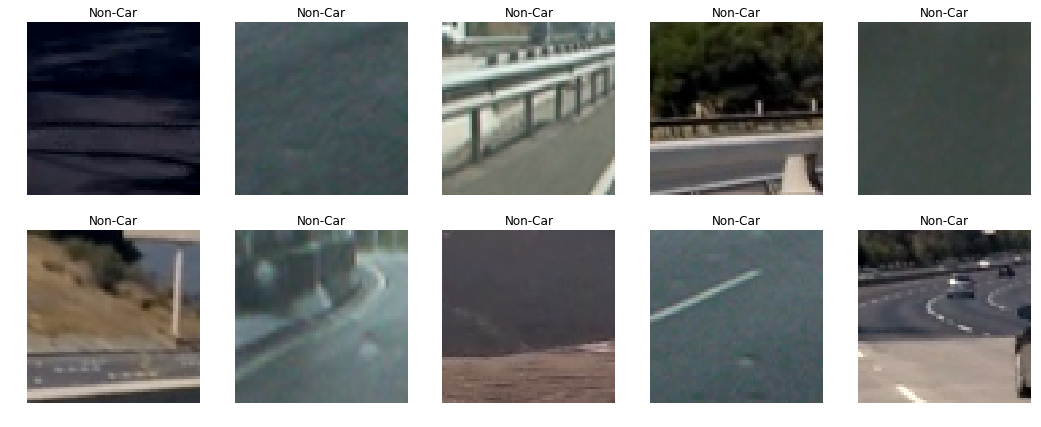

In [6]:
plot_img(non_car, 'Non-Car')

### Features Extraction

#### 1. Use HOG (Histogram of Oriented Gradients) Function

>In this step, extraction features from the images, Car and Non-Car images, by using HOG (Histogram of Oriented Gradients). <br> 
HOG function makes histogram of direction of oriented gradients in X and Y. <br>
Since the result contains magnitude and direction of gradients, it is really useful to classify between car and non-car images.

In [201]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, feature_vec=True):
    '''
    This function return hog feature and hog image, contains direction of oriented gradients in X and Y.
    '''
    return_list = hog(img, orientations=orient, 
                           pixels_per_cell=(pix_per_cell, pix_per_cell),
                           cells_per_block=(cell_per_block, cell_per_block),
                           block_norm='L2-Hys', 
                           transform_sqrt=False, 
                           visualise=True, 
                           feature_vector=feature_vec)
    
    # vis, visualize, decides whether return hog image or not
    hog_features = return_list[0]
    hog_image = return_list[1]
    return hog_features, hog_image

Orientations: 9
Pixels per Cell: (8, 8)
Cells per Block: (2, 2)


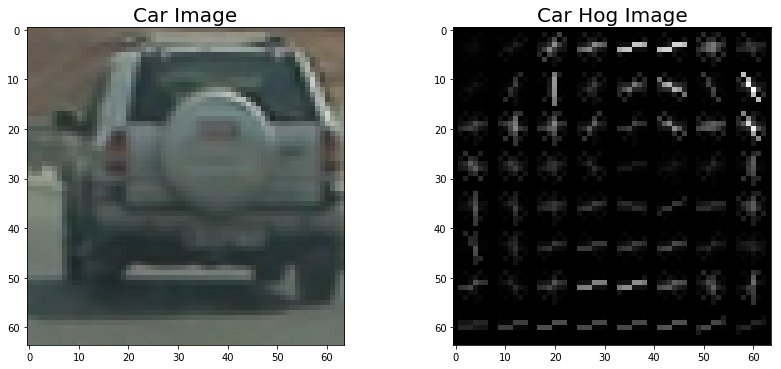

In [202]:
# Set params
random_int = random.randint(0, len(car))
orient = 9
pix_per_cell = 8
cell_per_block = 2
gray = cv2.cvtColor(mpimg.imread(car[random_int]), cv2.COLOR_RGB2GRAY)
_, hog_image = get_hog_features(gray, orient, pix_per_cell, cell_per_block)

print('Orientations:', orient)
print('Pixels per Cell:', (pix_per_cell, pix_per_cell))
print('Cells per Block:', (cell_per_block, cell_per_block))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
f.tight_layout()
ax1.imshow(mpimg.imread(car[random_int]))
ax1.set_title('Car Image', fontsize=20)
ax2.imshow(hog_image, cmap='gray')
ax2.set_title('Car Hog Image', fontsize=20);

Orientations: 9
Pixels per Cell: (8, 8)
Cells per Block: (2, 2)


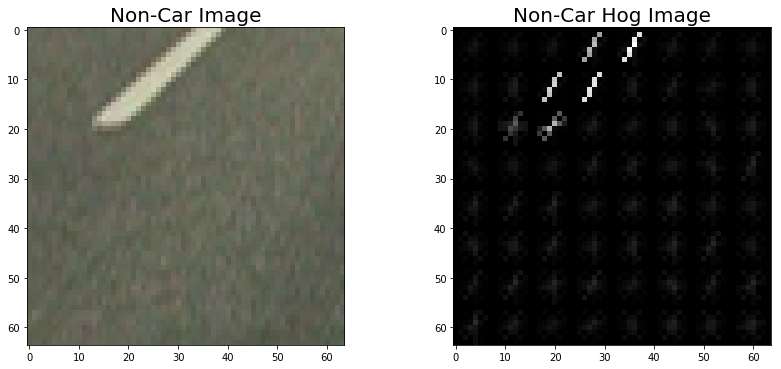

In [203]:
# Set params
random_int = random.randint(0, len(car))
orient = 9
pix_per_cell = 8
cell_per_block = 2
gray = cv2.cvtColor(mpimg.imread(non_car[random_int]), cv2.COLOR_RGB2GRAY)
_, hog_image = get_hog_features(gray, orient, pix_per_cell, cell_per_block)

print('Orientations:', orient)
print('Pixels per Cell:', (pix_per_cell, pix_per_cell))
print('Cells per Block:', (cell_per_block, cell_per_block))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
f.tight_layout()
ax1.imshow(mpimg.imread(non_car[random_int]))
ax1.set_title('Non-Car Image', fontsize=20)
ax2.imshow(hog_image, cmap='gray')
ax2.set_title('Non-Car Hog Image', fontsize=20);

In [ ]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel() 
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors
    features = []                      
    for file in imgs:
        image = mpimg.imread(file)
        
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      
        
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features)))
        
    return features, spatial_features, hist_features

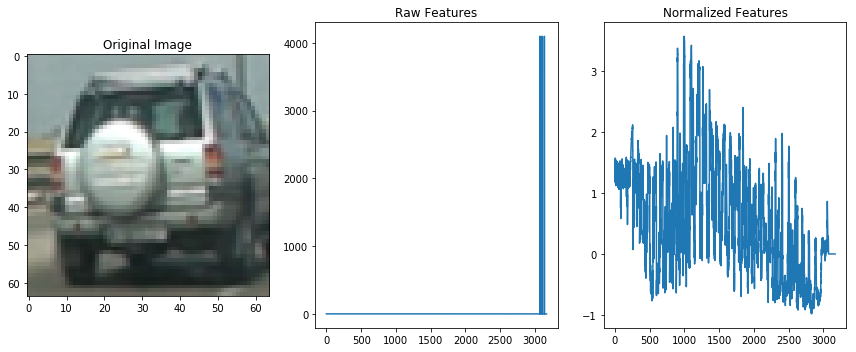

In [11]:
car_features = extract_features(car, cspace='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256))
noncar_features = extract_features(non_car, cspace='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256))

# Create an array stack of feature vectors
X = np.vstack((car_features, noncar_features)).astype(np.float64)     

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)

# Apply the scaler to X
scaled_X = X_scaler.transform(X)
random_int = random.randint(0, len(car))

# Plot an example of raw and scaled features
fig = plt.figure(figsize=(12, 5))
plt.subplot(131)
plt.imshow(mpimg.imread(car[random_int]))
plt.title('Original Image')
plt.subplot(132)
plt.plot(X[random_int])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X[random_int])
plt.title('Normalized Features')
fig.tight_layout()

In [401]:
def extract_features(imgs, cspace='RGB', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel='All'):
    '''
    This function to extract features from a list of image locations
    '''
    features = []                                         # Create a list to append feature vectors
    for file in imgs:
        image = mpimg.imread(file)
        if cspace != 'RGB':                               # apply color conversion if other than 'RGB'
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
        # Call get_hog_features() with vis=False, feature_vec=True
        channels = feature_image.shape[2]           # number of channels
        if hog_channel == 'All':
            hog_features = []
            for chan in range(channels):
                hog_feat, _ = get_hog_features(feature_image[:,:,chan], orient, pix_per_cell, cell_per_block)
                hog_features.append(hog_feat)
            hog_features = np.ravel(hog_features)        
        
        else:
            hog_features, _ = get_hog_features(feature_image[:,:,0], orient, pix_per_cell, cell_per_block)
        
        features.append(hog_features)            # Append the new feature vector to the features list
        
    return features

In [402]:
# Feature extraction parameters
colorspace = 'RGB'
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'All' 

car_features = extract_features(car, 
                                cspace=colorspace, 
                                orient=orient, 
                                pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel)

noncar_features = extract_features(non_car, 
                                   cspace=colorspace, 
                                   orient=orient, 
                                   pix_per_cell=pix_per_cell, 
                                   cell_per_block=cell_per_block, 
                                   hog_channel=hog_channel)

# Create an array stack of feature vectors
X = np.vstack((car_features, noncar_features)).astype(np.float64)   

X_scaler = StandardScaler().fit(X)              # Fit a per-column scaler
scaled_X = X_scaler.transform(X)                # Apply the scaler to X

y = np.hstack((np.ones(len(car_features)), np.zeros(len(noncar_features))))       # Define the labels vector

# Split train and test data, 80% of Train_set and 20% of Test_set
Xtr, Xte, ytr, yte = train_test_split(scaled_X, y, test_size=0.2, random_state=7)

print('Orientations:', orient)
print('Pixels per Cell:', (pix_per_cell, pix_per_cell))
print('Cells per Block:', (cell_per_block, cell_per_block))
print('Size of Feature vector:', len(Xtr[0]))

Orientations: 9
Pixels per Cell: (8, 8)
Cells per Block: (2, 2)
Size of Feature vector: 5292


In [403]:
svc = LinearSVC()                               # Use Linear SVC, Linear Support Vector Classification
t0 = time.time()
svc.fit(Xtr, ytr)
t1 = time.time()
print('SVC Model Training Time:', round(t1-t0, 2), 'sec')

score = svc.score(Xte, yte)                     # Check the score of the SVC
print('Accuracy:', round(score, 4))

n_pred = 10
print('Real Label(Car/Non-Car): ', yte[0:n_pred])
print('Predict Label(Car/Non-Car): ', svc.predict(Xte[0:n_pred]))
print('\n**If Predict Value is 1, it is Car.')
print('  Else Predict Value is 0, it is Non-Car.')

SVC Model Training Time: 36.23 sec
Accuracy: 0.9175
Real Label(Car/Non-Car):  [1. 1. 0. 1. 0. 1. 1. 0. 1. 1.]
Predict Label(Car/Non-Car):  [1. 1. 0. 1. 0. 1. 1. 0. 1. 1.]

**If Predict Value is 1, it is Car.
  Else Predict Value is 0, it is Non-Car.


### Find The Best Params & Train Classifier

In [404]:
'''
6 x 5 x 2 x 2 = 120, there are 120 different possible set of params.
This function is to find the best set of params 
in the accuracy score of SVC based on in different set of params(colorspace, orientations, pix_per_cell and hog_channel).
One param, cell_per_block, fix the values in cell_per_block = 2 
And param, hog_channel, has two options hog_channel = 'All' or hog_channel = 0, which is only one channel applied.
'''
colorspace = ['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb']
orient = [8, 9, 10, 11, 12]
pix_per_cell = [8, 16]
cell_per_block = 2
hog_channel = [0, 'All']

result = []
for c in range(len(colorspace)):
    for o in range(len(orient)):
        for p in range(len(pix_per_cell)):
            for h in range(len(hog_channel)):
                car_features = extract_features(car, 
                                                cspace=colorspace[c], 
                                                orient=orient[o], 
                                                pix_per_cell=pix_per_cell[p], 
                                                cell_per_block=cell_per_block, 
                                                hog_channel=hog_channel[h])

                noncar_features = extract_features(non_car, 
                                                   cspace=colorspace[c], 
                                                   orient=orient[o], 
                                                   pix_per_cell=pix_per_cell[p], 
                                                   cell_per_block=cell_per_block, 
                                                   hog_channel=hog_channel[h])

                # Create an array stack of feature vectors
                X = np.vstack((car_features, noncar_features)).astype(np.float64)   

                X_scaler = StandardScaler().fit(X)               # Fit a per-column scaler
                scaled_X = X_scaler.transform(X)                 # Apply the scaler to X

                y = np.hstack((np.ones(len(car_features)), np.zeros(len(noncar_features))))   # Define the labels vector

                # Split train and test data, 80% of Train_set and 20% of Test_set
                Xtr, Xte, ytr, yte = train_test_split(scaled_X, y, test_size=0.2, random_state=7)

                svc = LinearSVC()                                # Use Linear SVC, Linear Support Vector Classification
                svc.fit(Xtr, ytr) 
                score = round(svc.score(Xte, yte), 4)             # Check the score of the SVC
                result.append([colorspace[c], orient[o], pix_per_cell[p], hog_channel[h], score])

# Make pandas Dataframe all result                          
param = pd.DataFrame(data=result, columns=['Color_Space', 'Orientations', 'Pixel per Cell', 'Channel', 'Score'])

In [405]:
# Top 10 accuracy score in multiple set of params
param.sort_values(['Score'], ascending=False)[:10]

Color_Space  Orientations  Pixel per Cell Channel   Score
111       YCrCb            10              16     All  0.9797
91          YUV            10              16     All  0.9789
43          LUV             8              16     All  0.9783
51          LUV            10              16     All  0.9761
103       YCrCb             8              16     All  0.9755
99          YUV            12              16     All  0.9755
83          YUV             8              16     All  0.9755
47          LUV             9              16     All  0.9752
87          YUV             9              16     All  0.9747
119       YCrCb            12              16     All  0.9741

### SVM Classification

In [58]:
reset -sf

In [59]:
import pandas as pd
import numpy as np
import random
import cv2 
import glob
import time

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.feature import hog
from sklearn.svm import LinearSVC
from scipy.ndimage.measurements import label
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from moviepy.editor import VideoFileClip

In [60]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, feature_vec=True):
    '''
    This function return hog feature and hog image, contains direction of oriented gradients in X and Y.
    '''
    return_list = hog(img, orientations=orient, 
                           pixels_per_cell=(pix_per_cell, pix_per_cell),
                           cells_per_block=(cell_per_block, cell_per_block),
                           block_norm='L2-Hys', 
                           transform_sqrt=False, 
                           visualise=True, 
                           feature_vector=feature_vec)
    
    # vis, visualize, decides whether return hog image or not
    hog_features = return_list[0]
    hog_image = return_list[1]
    return hog_features, hog_image

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel() 
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    
    return hist_features

In [61]:
def train_pipline(imgs, cspace='LUV',  
                        orient=8, 
                        pix_per_cell=8, 
                        cell_per_block=2, 
                        hog_channel=0,
                        spatial_size=16, 
                        hist_bins=32):
    '''
    This function to extract features from a list of image locations
    '''
    features = []                                         # Create a list to append feature vectors
    for file in imgs:
        single_feature = []                               # Create a list to append feature vectors for single image
        image = mpimg.imread(file)
        if cspace != 'RGB':                               # apply color conversion if other than 'RGB'
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
        
        if spatial_size > 0:
            # Apply bin_spatial() to get spatial color features
            spatial_features = bin_spatial(feature_image, size=(spatial_size, spatial_size))
            single_feature.append(spatial_features)
            ###print('1',spatial_features.shape)
        
        if hist_bins > 0:
            # Apply color_hist() also with a color space option now
            hist_features = color_hist(feature_image, nbins=hist_bins)
            single_feature.append(hist_features)
            ###print('2',hist_features.shape)
        
        channels = feature_image.shape[2]           # number of channels
        if hog_channel == 'All':
            hog_features = []
            for chan in range(channels):
                hog_feat, _ = get_hog_features(feature_image[:,:,chan], orient, pix_per_cell, cell_per_block)
                hog_features.append(hog_feat)
            hog_features = np.ravel(hog_features)        

        else:
            hog_features, _ = get_hog_features(feature_image[:,:,0], orient, pix_per_cell, cell_per_block)
            ###print('3',hog_features.shape)
        
        single_feature.append(hog_features)               # Append the new feature vector to the features list
        ###print(len(single_feature[0]), len(single_feature[1]), len(single_feature[2]))
        features.append(np.concatenate(single_feature)) 
        
    return features

In [62]:
car = glob.glob('./train_set/vehicles/**/*.png')
non_car = glob.glob('./train_set/non-vehicles/**/*.png')

#### With Combine Features, [Spatial, Hist, HOG]

In [67]:
# Feature extraction parameters
cspace='LUV'  
orient=8
pix_per_cell=8
cell_per_block=2 
hog_channel=0,
spatial_size=16
hist_bins=32

car_features = train_pipline(car, 
                             cspace=cspace, 
                             orient=orient, 
                             pix_per_cell=pix_per_cell, 
                             cell_per_block=cell_per_block, 
                             hog_channel=hog_channel,
                             spatial_size=spatial_size, 
                             hist_bins=hist_bins)

noncar_features = train_pipline(non_car, 
                                cspace=cspace, 
                                orient=orient, 
                                pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel,
                                spatial_size=spatial_size, 
                                hist_bins=hist_bins)

# Create an array stack of feature vectors
X = np.vstack((car_features, noncar_features)).astype(np.float64)   

X_scaler = StandardScaler().fit(X)              # Fit a per-column scaler
scaled_X = X_scaler.transform(X)                # Apply the scaler to X

y = np.hstack((np.ones(len(car_features)), np.zeros(len(noncar_features))))       # Define the labels vector

# Split train and test data, 80% of Train_set and 20% of Test_set
Xtr, Xte, ytr, yte = train_test_split(scaled_X, y, test_size=0.2, random_state=7)

print('Orientations:', orient)
print('Pixels per Cell:', (pix_per_cell, pix_per_cell))
print('Cells per Block:', (cell_per_block, cell_per_block))
print('Size of Feature vector:', len(Xtr[0]))

svc = LinearSVC()                               # Use Linear SVC, Linear Support Vector Classification
t0 = time.time()
svc.fit(Xtr, ytr)
t1 = time.time()
print('SVC Model Training Time:', round(t1-t0, 2), 'sec')

score = svc.score(Xte, yte)                     # Check the score of the SVC
print('Accuracy:', round(score, 4))

n_pred = 10
print('Real Label(Car/Non-Car): ', yte[0:n_pred])
print('Predict Label(Car/Non-Car): ', svc.predict(Xte[0:n_pred]))
print('\n**If Predict Value is 1, it is Car.')
print('  Else Predict Value is 0, it is Non-Car.')

Orientations: 8
Pixels per Cell: (8, 8)
Cells per Block: (2, 2)
Size of Feature vector: 2432
SVC Model Training Time: 8.16 sec
Accuracy: 0.9693
Real Label(Car/Non-Car):  [1. 1. 0. 1. 0. 1. 1. 0. 1. 1.]
Predict Label(Car/Non-Car):  [1. 0. 0. 1. 0. 1. 1. 0. 1. 1.]

**If Predict Value is 1, it is Car.
  Else Predict Value is 0, it is Non-Car.


In [133]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    '''
    Define a function to draw bounding boxes on an image
    '''
    imcopy = np.copy(img)     # Make a copy of the image
    for bbox in bboxes:       # Iterate through the bounding boxes
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy

In [137]:
def find_cars(img,
              ystart, 
              ystop, 
              scale,
              svc,
              X_scaler,
              cspace='LUV',  
              orient=8, 
              pix_per_cell=8, 
              cell_per_block=2, 
              hog_channel=0,
              spatial_size=16, 
              hist_bins=32):
    '''
    Define a single function that can extract features using hog sub-sampling and make predictions
    '''

    # array of rectangles where cars were detected
    boxes = []

    img = img.astype(np.float32)/255
    search = img[ystart:ystop, :, :]

    if cspace != 'RGB':                               # apply color conversion if other than 'RGB'
        if cspace == 'HSV':
            src_image = cv2.cvtColor(search, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            src_image = cv2.cvtColor(search, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            src_image = cv2.cvtColor(search, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            src_image = cv2.cvtColor(search, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            src_image = cv2.cvtColor(search, cv2.COLOR_RGB2YCrCb)
    else: src_image = np.copy(search)     

    # rescale image if other than 1.0 scale
    if scale != 1:
        y, x = src_image.shape[:2]
        src_image = cv2.resize(src_image, (np.int(x/scale), np.int(y/scale)))

    # Define blocks and steps as above
    y, x = src_image.shape[:2]
    nxblocks = (x//pix_per_cell)+1  
    nyblocks = (y//pix_per_cell)+1  
    nfeat_per_block = orient*cell_per_block**2

    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    cells_per_step = 2                                 # Instead of overlap, define how many cells to step
    nblocks_per_window = (window//pix_per_cell)-1 
    nxsteps = (nxblocks-nblocks_per_window) // cells_per_step
    nysteps = (nyblocks-nblocks_per_window) // cells_per_step


    channels = src_image.shape[2]           # number of channels
    if hog_channel == 'All':
        hog_feat_temp = []
        for chan in range(channels):
            hog_feat, _ = get_hog_features(src_image[:,:,chan], 
                                           orient, 
                                           pix_per_cell, 
                                           cell_per_block, 
                                           feature_vec=False)
            hog_feat_temp.append(hog_feat)

    else:
        hog_feat, _ = get_hog_features(src_image[:,:,0], 
                                       orient, 
                                       pix_per_cell, 
                                       cell_per_block, 
                                       feature_vec=False)

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step

            # Extract HOG for this patch
            if hog_channel == 'All':
                hog_feat_0 = hog_feat_temp[0][ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat_1 = hog_feat_temp[1][ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat_2 = hog_feat_temp[2][ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                hog_features = np.hstack((hog_feat_0, hog_feat_1, hog_feat_2))
            else:
                hog_features = hog_feat[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()


            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            #Extract the image patch
            subimg = cv2.resize(src_image[ytop:ytop+window, xleft:xleft+window], (64, 64))

            #Get color features
            spatial_features = bin_spatial(subimg, size=(spatial_size, spatial_size))
            hist_features = color_hist(subimg, nbins=hist_bins)
            ###print(spatial_features.shape, hist_features.shape)
            ###print('2',hog_features.shape)


            #Scale features and make a prediction
            combine_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            pred = svc.predict(combine_features)

            if pred == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))

    return boxes

In [167]:
def vehicle(img, svc, X_scaler, scale=1.0, overlap=0.75):
    '''
    This function search vehicles on the image in differnet window size(box), scale, and locations.
    '''
    boxes = []
    cspace = 'LUV' 
    orient = 8
    pix_per_cell = 8
    
    for _ in range(4):
        num_iter = 4
        while num_iter > 0:
            num_iter-=1
            ystart = 400
            window = 64
            ystop = ystart + int(window*scale)
            box = find_cars(img, 
                            ystart, 
                            ystop, 
                            scale, 
                            svc, 
                            X_scaler, 
                            cspace=cspace, 
                            orient=orient, 
                            pix_per_cell=pix_per_cell)

            boxes.append(box)
            ystart+=int(window*overlap)
            ystop = ystart+int(window*scale)
            
        num_iter-=1
        scale+=0.5
    
    boxes = [b for box in boxes for b in box]
    return boxes

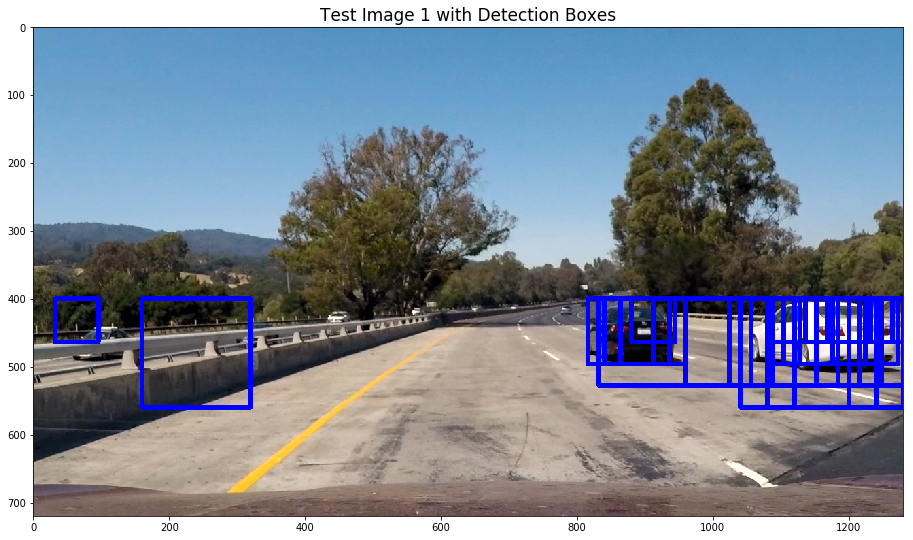

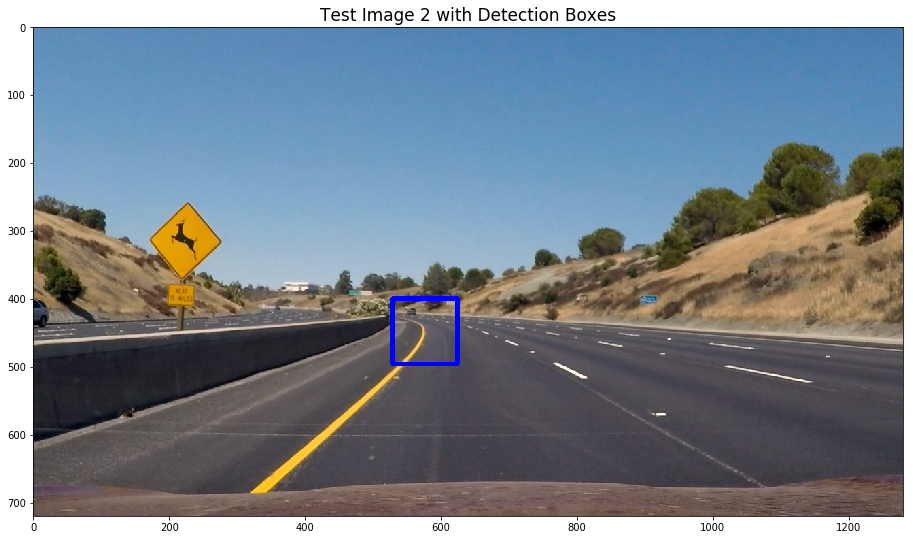

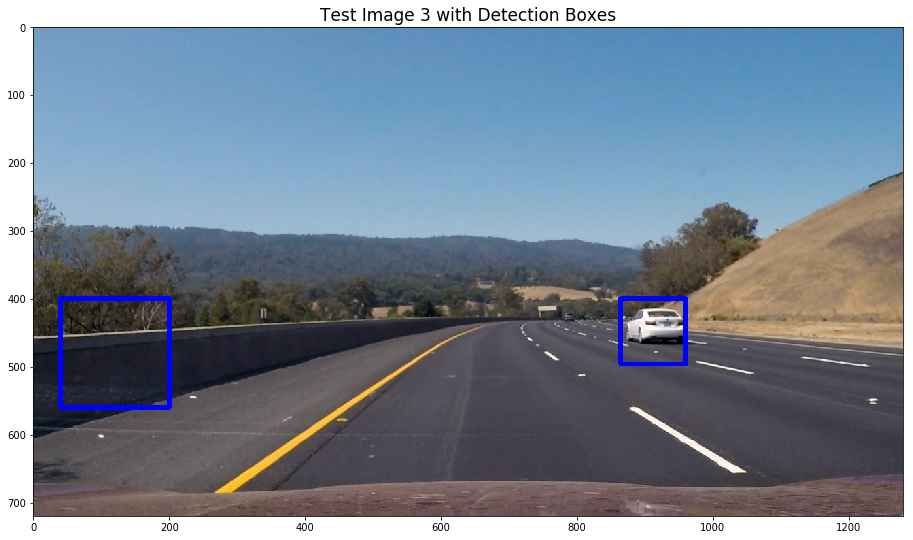

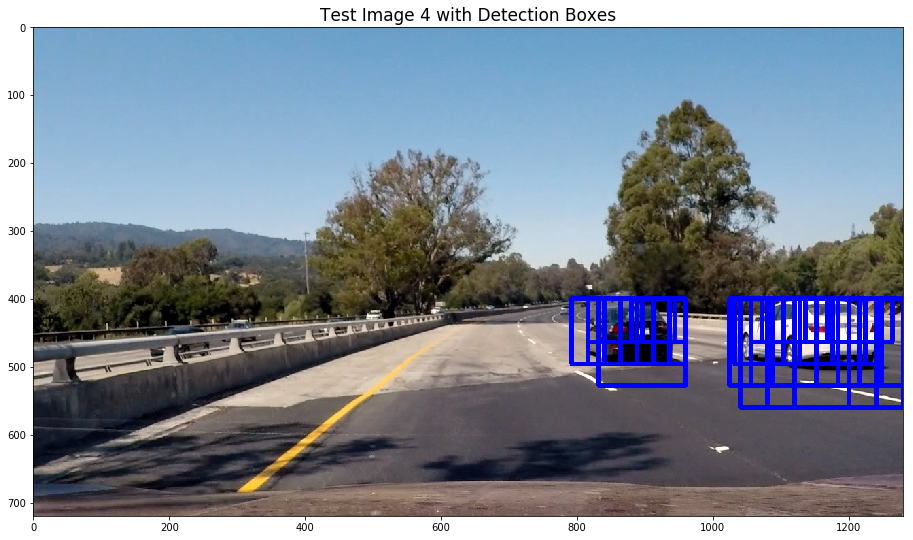

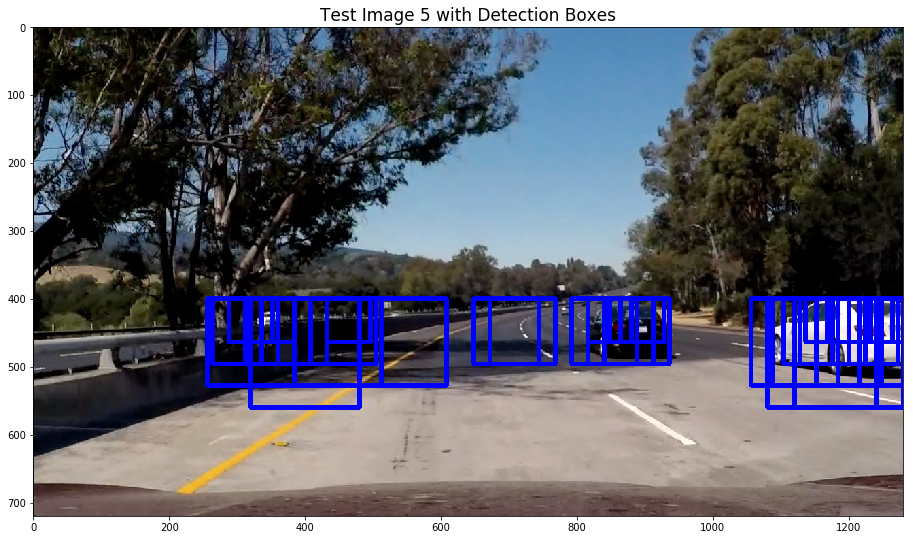

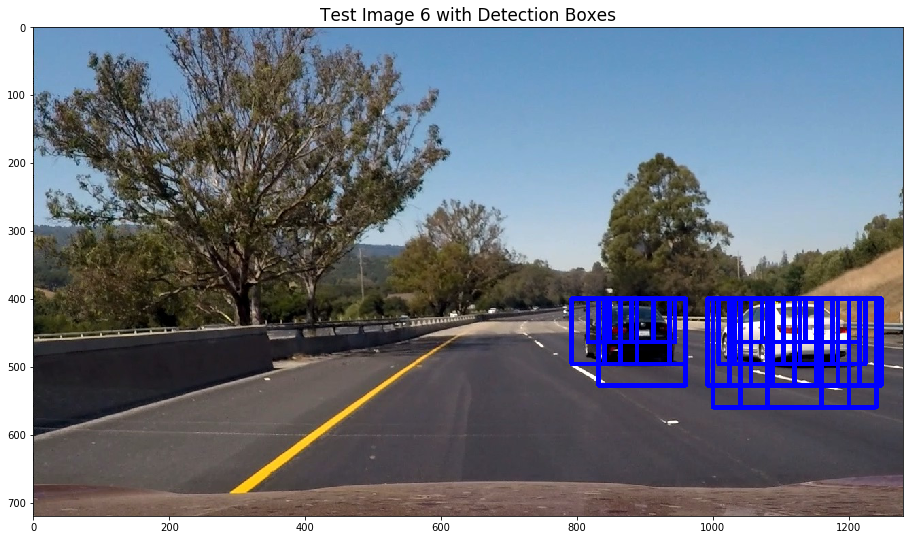

In [168]:
images = glob.glob('./test_images/*.jpg')
for i in range(0, len(images), 1):
    img = mpimg.imread(images[i])
    
    boxes = vehicle(img, svc, X_scaler)
    box_img = draw_boxes(img, boxes)
    
    plt.figure(figsize=(18, 9))
    plt.title('Test Image {0} with Detection Boxes'.format(i+1), fontsize=17)
    plt.imshow(box_img)
plt.show()

In [169]:
def add_heat(heatmap, bbox_list):
    '''
    Add += 1 for all pixels inside each bbox
    Assuming each "box" takes the form ((x1, y1), (x2, y2))
    '''
    for box in bbox_list:                     # Iterate through list of bboxes
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap

def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0         # Zero out pixels below the threshold
    return heatmap

def final_box(img, l):
    boxes = []                
    for car in range(1, l[1]+1):                         # Iterate through all detected cars
        nonzero = (l[0] == car).nonzero()                # Find pixels with each car labeled value
        nonzeroy = np.array(nonzero[0])                  # Identify x and y values of those pixels
        nonzerox = np.array(nonzero[1])
        
        box = ((np.min(nonzerox), np.min(nonzeroy)),     # Define a bounding box based on min/max x and y
               (np.max(nonzerox), np.max(nonzeroy)))
        
        boxes.append(box)
        cv2.rectangle(img, box[0], box[1], (0, 0, 255), 6)
    return img

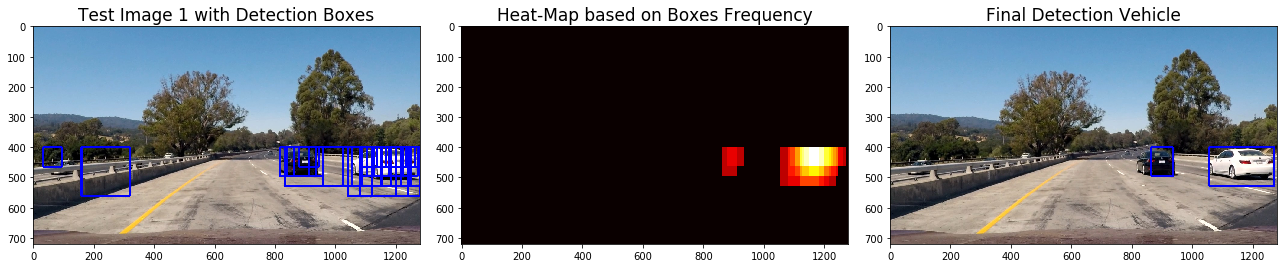

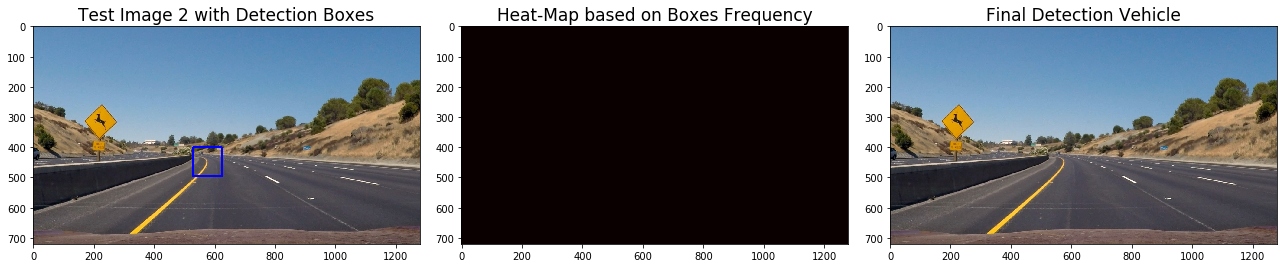

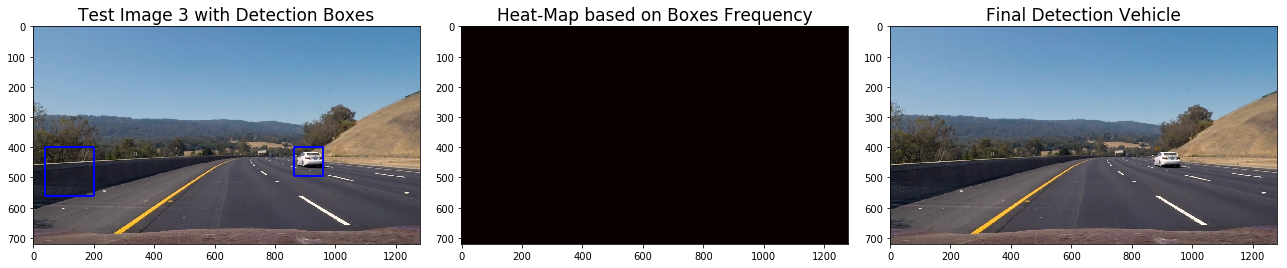

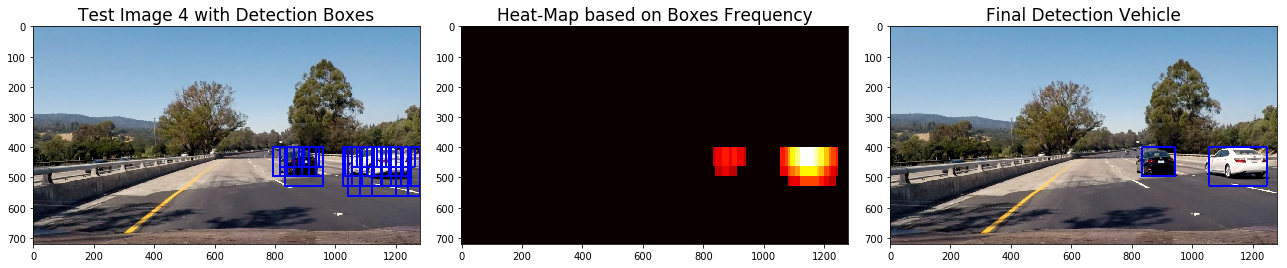

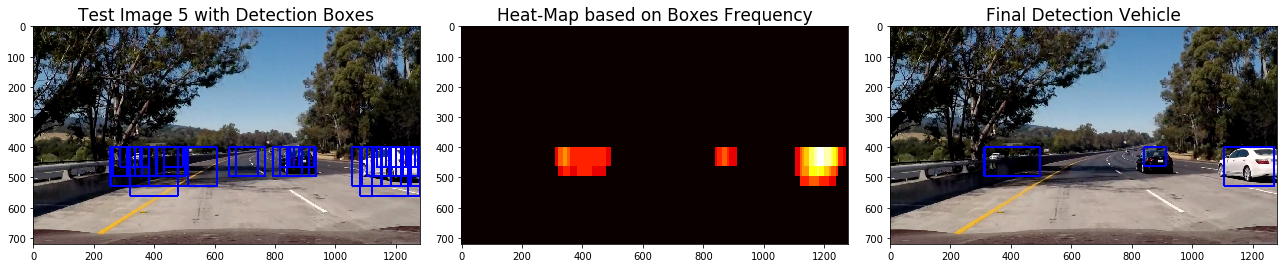

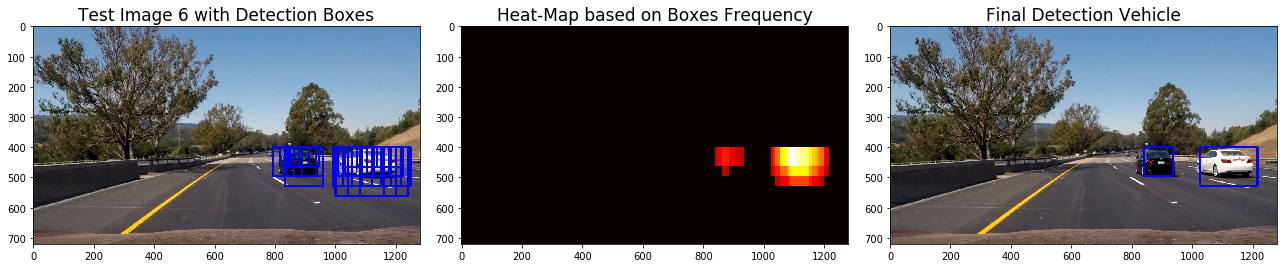

In [170]:
images = glob.glob('./test_images/*.jpg')
for i in range(0, len(images), 1):
    img = mpimg.imread(images[i])
    
    boxes = vehicle(img, svc, X_scaler)
    box_img = draw_boxes(img, boxes)
    
    heatmap = np.zeros_like(box_img[:,:,0])
    heatmap = add_heat(heatmap, boxes)
    heatmap = apply_threshold(heatmap, 15)
    
    l = label(heatmap)
    result = final_box(np.copy(img), l)
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 9))
    f.tight_layout()
    ax1.imshow(box_img);
    ax1.set_title('Test Image {0} with Detection Boxes'.format(i+1), fontsize=17)
    ax2.imshow(heatmap, cmap='hot');
    ax2.set_title('Heat-Map based on Boxes Frequency'.format(i+1), fontsize=17)
    ax3.imshow(result);
    ax3.set_title('Final Detection Vehicle'.format(i+1), fontsize=17)

In [100]:
from laneLine import Line
from line_function import *

In [101]:
mtx, dist = calibration()

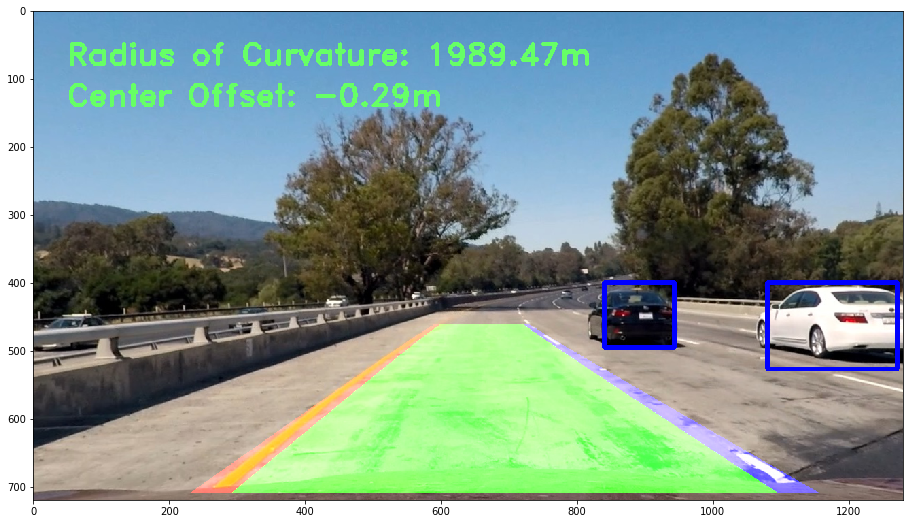

In [148]:
img = mpimg.imread('./test_images/test1.jpg')

boxes = vehicle(img, svc, X_scaler)

heatmap = np.zeros_like(img[:,:,0])
heatmap = add_heat(heatmap, boxes)
heatmap = apply_threshold(heatmap, 15)

line = Line(mtx, dist)
prod = line.laneFind(img)

l = label(heatmap)
result = final_box(np.copy(prod), l)

plt.figure(figsize=(18, 9))
plt.imshow(result);
plt.show()

In [159]:
class Detect():
    def __init__(self, svc, X_scaler):
        self.svc = svc
        self.X_scaler = X_scaler
        self.prev_boxes = []       # history of rectangles previous n frames
        
    def add_boxes(self, boxes):
        self.prev_boxes.append(boxes)
        if len(self.prev_boxes) > 5:
            self.prev_boxes = self.prev_boxes[len(self.prev_boxes)-5:]    # throw out oldest rectangle set(s)

    def video_pipline(self, img):
        boxes = vehicle(img, svc, X_scaler)
        
        if len(boxes) > 0:             # add detections to the history
            Det.add_boxes(boxes)

        heatmap = np.zeros_like(img[:,:,0])
        for box in self.prev_boxes:
            heatmap = add_heat(heatmap, box)
        heatmap = apply_threshold(heatmap, 75 + len(self.prev_boxes)//2)

        line = Line(mtx, dist)
        prod = line.laneFind(img)
        
        l = label(heatmap)
        result = final_box(np.copy(prod), l)
        
        return result

In [171]:
Det = Detect(svc, X_scaler)

output = "./output_video/test_output.mp4"
clip1 = VideoFileClip("test_video.mp4")
white_clip = clip1.fl_image(Det.video_pipline)
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video ./output_video/test_output.mp4
[MoviePy] Writing video ./output_video/test_output.mp4



 97%|█████████▋| 38/39 [02:05<00:03,  3.31s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_video/test_output.mp4 

CPU times: user 2min 7s, sys: 4.78 s, total: 2min 12s
Wall time: 2min 7s


In [174]:
Det = Detect(svc, X_scaler)

output = "./output_video/project_output.mp4"
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(Det.video_pipline)
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video ./output_video/project_output.mp4
[MoviePy] Writing video ./output_video/project_output.mp4



 12%|█▏        | 147/1261 [08:09<1:01:52,  3.33s/it]


 24%|██▎       | 297/1261 [15:52<51:32,  3.21s/it]


 36%|███▌      | 448/1261 [23:39<42:56,  3.17s/it]


 48%|████▊     | 599/1261 [31:26<34:44,  3.15s/it]


 59%|█████▉    | 750/1261 [39:10<26:41,  3.13s/it]


 71%|███████▏  | 901/1261 [46:56<18:45,  3.13s/it]


 83%|████████▎ | 1051/1261 [54:42<10:55,  3.12s/it]


 95%|█████████▌| 1198/1261 [1:02:16<03:16,  3.12s/it]


100%|█████████▉| 1260/1261 [1:05:27<00:03,  3.12s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_video/project_output.mp4 

CPU times: user 1h 7min 6s, sys: 2min, total: 1h 9min 6s
Wall time: 1h 5min 28s
